In [31]:
#chack for updated files\n,
%load_ext autoreload
%autoreload 2
#import packages
from __future__ import division

import numpy as np
import glob, json
import pickle
import os as os_pack
import matplotlib.pyplot as plt
import corner
#%matplotlib inline\n",
%config InlineBackend.figure_format = 'retina'
import healpy as hp
import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise_extensions import blocks
from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import model_orfs
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LogLikelihood
import enterprise_wavelets as models
from enterprise.signals.deterministic_signals import Deterministic
from enterprise.signals.parameter import function
from la_forge.core import Core
from la_forge.diagnostics import plot_chains
from la_forge import rednoise
import la_forge
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import re
#style
    
#import Fast_Burst_likelihood as FB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Loading in pickle and noise files
pint_pickle = '/home/reyna/OS_15yr/15yr_data/v1p1_de440_pint_bipm2019.pkl'
noise_file = '/home/reyna/OS_15yr/15yr_data/v1p1_wn_dict.json'
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file, 'r') as h:
    noise_params = json.load(h)
with open(pint_pickle,'rb') as f:
    allpsrs = pickle.load(f)
psrs = []
for ii,p in enumerate(allpsrs):
    psrs.append(p)
#Temporary to get code to not crash
psrs = psrs[0:10]
psrlist = [psr.name for psr in psrs]
print(psrlist)
for i in range(len(psrs)):
    print((max(psrs[i].toas) - min(psrs[i].toas))/(3.17*10**(7)))

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J0340+4130', 'J0406+3039', 'J0437-4715', 'J0509+0856', 'J0557+1551']
15.515060297068947
15.802872967471835
11.08458774068679
8.97542529762611
15.460752938661816
8.097196263848735
3.5471797714338695
4.73231500896138
3.547176454921115
4.544545768066009


In [3]:
parDir =  '/home/reyna/BayesHopperBurst/QuickBurst/Single_Transient_Simulated_Data/pars/'
timDir =  '/home/reyna/BayesHopperBurst/QuickBurst/Single_Transient_Simulated_Data/tims/'
psrlist = sorted(glob.glob(parDir+'*.par'))
for _ in range(len(psrlist)):
    psrlist[_] = re.sub(parDir, '', psrlist[_])
    psrlist[_] = re.sub('_NANOGrav_12yv2.gls.par', '', psrlist[_])
parfiles = sorted(glob.glob(parDir+'*.par'))
timfiles = sorted(glob.glob(timDir+'*.tim'))
psrs_sim = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=None, clk=None)
    psrs_sim.append(psr)

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [4]:
#Loading in pickle and noise files
noise_file_sim = "/home/reyna/BayesHopperBurst/BenceData/with_burst/params_simulated.json"
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file_sim, 'r') as h:
    noise_params_sim = json.load(h)
#Temporary to get code to not crash
psrs_sim = psrs_sim[0:8]
psrlist = [psr.name for psr in psrs_sim]
print(psrlist)
for i in range(len(psrs_sim)):
    print((max(psrs_sim[i].toas) - min(psrs_sim[i].toas))/(3.17*10**(7)))

['JPSR00', 'JPSR01', 'JPSR02', 'JPSR03', 'JPSR04', 'JPSR05', 'JPSR06', 'JPSR07']
9.893753204746307
9.893759921988087
9.893754816178342
9.893759889756392
9.893756654153247
9.89375896654812
9.89374832210285
9.893748096020424


In [5]:
noise_dict_sim = {} #new noise dict to conver the simulated noise file into a readable formate
for k,v in noise_params_sim.items():
    if '_equad' in k:
        noise_dict_sim.update({k.split('_equad')[0] + '_t2equad': v})
    else:
        noise_dict_sim.update({k : v})

In [6]:
noise_dict_sim

{'JPSR00_efac': 1.0,
 'JPSR01_efac': 1.0,
 'JPSR02_efac': 1.0,
 'JPSR03_efac': 1.0,
 'JPSR04_efac': 1.0,
 'JPSR05_efac': 1.0,
 'JPSR06_efac': 1.0,
 'JPSR07_efac': 1.0,
 'JPSR08_efac': 1.0,
 'JPSR09_efac': 1.0,
 'JPSR10_efac': 1.0,
 'JPSR11_efac': 1.0,
 'JPSR12_efac': 1.0,
 'JPSR13_efac': 1.0,
 'JPSR14_efac': 1.0,
 'JPSR15_efac': 1.0,
 'JPSR16_efac': 1.0,
 'JPSR17_efac': 1.0,
 'JPSR18_efac': 1.0,
 'JPSR19_efac': 1.0,
 'JPSR00_log10_t2equad': -17,
 'JPSR01_log10_t2equad': -17,
 'JPSR02_log10_t2equad': -17,
 'JPSR03_log10_t2equad': -17,
 'JPSR04_log10_t2equad': -17,
 'JPSR05_log10_t2equad': -17,
 'JPSR06_log10_t2equad': -17,
 'JPSR07_log10_t2equad': -17,
 'JPSR08_log10_t2equad': -17,
 'JPSR09_log10_t2equad': -17,
 'JPSR10_log10_t2equad': -17,
 'JPSR11_log10_t2equad': -17,
 'JPSR12_log10_t2equad': -17,
 'JPSR13_log10_t2equad': -17,
 'JPSR14_log10_t2equad': -17,
 'JPSR15_log10_t2equad': -17,
 'JPSR16_log10_t2equad': -17,
 'JPSR17_log10_t2equad': -17,
 'JPSR18_log10_t2equad': -17,
 'JPSR19_l

In [32]:
glitches = []
log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("Glitch_"+str(1)+'_'+'log10_f0')
phase0 = parameter.Uniform(0, 2*np.pi)("Glitch_"+str(1)+'_'+'phase0')
tau = parameter.Uniform(0.2, 5)("Glitch_"+str(1)+'_'+'tau')
t0 = parameter.Uniform(0.0, 10.0)("Glitch_"+str(1)+'_'+'t0')
psr_idx = parameter.Uniform(-0.5, len(psrs)-0.5)("Glitch_"+str(1)+'_'+'psr_idx')
log10_h = parameter.LinearExp(-6.5, -5)("Glitch_"+str(1)+'_'+'log10_h')
glitch_wf = models.glitch_delay(log10_h = log10_h, tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, tref=53000*86400,
                                        psr_float_idx = psr_idx, pulsars=psrs)
glitches.append(deterministic_signals.Deterministic(glitch_wf, name='Glitch'+str(1) ))

In [33]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=False)
#s = base_model
s = tm + wn + glitches[0]
model = []
for p in psrs:
    model.append(s(p))
with open(noise_file, 'r') as fp:
    noisedict = json.load(fp)
    pta = signal_base.PTA(model)
    pta.set_default_params(noisedict)

In [38]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=False)
#s = base_model
s = tm + wn + glitches[0]
model_sim = []
for p in psrs_sim:
    model_sim.append(s(p))
# with open(noise_file_sim, 'r') as fp:
#     noisedict = json.load(fp)
pta_sim = signal_base.PTA(model_sim)
pta_sim.set_default_params(noise_dict_sim)

In [35]:
d0 = parameter.sample(pta.params)
x0 = np.array([d0[par.name] for par in pta.params])

In [36]:
d0 = {
    'Glitch_1_log10_f0':np.log10(6e-8),
#    'Glitch_1_log10_h':np.log10(1e-5), #medium amp
    'Glitch_1_log10_h':np.log10(2e-6), #low amp
#    'Glitch_1_log10_h':np.log10(1e-6), #very low amp
    'Glitch_1_phase0':1.0,
    'Glitch_1_psr_idx':0.2,#0.0 should be what is in file
    'Glitch_1_t0':2500.0/365.25, #year
    'Glitch_1_tau':300.0/365.25, #year
}
x0 = np.array([d0[par.name] for par in pta.params])

In [12]:
pta_sim.get_lnlikelihood(x0)

9802.949539294423

In [13]:
pta.get_lnlikelihood(x0)

idx not error


756011.7857661636

In [14]:
#low amp
9802.949539294423
9802.949539294423
9851.069441744154

9851.069441744154

In [15]:
9802.949539294423
9802.949539294423
9275.625502179333

9275.625502179333

In [16]:
d0

{'Glitch_1_log10_f0': -7.221848749616356,
 'Glitch_1_log10_h': -5.698970004336019,
 'Glitch_1_phase0': 1.0,
 'Glitch_1_psr_idx': 0.2,
 'Glitch_1_t0': 6.844626967830253,
 'Glitch_1_tau': 0.8213552361396304}

In [17]:
import Fast_Burst_likelihood as FB

In [18]:
FB1 = FB.FastBurst(pta = pta_sim, psrs = psrs_sim, params = d0, Npsr = len(psrs_sim), tref=53000*86400)

Nvecs arary:  [[2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5

9802.949539294423


In [19]:
FB1.get_lnlikelihood(10**(x0[1]), x0[2], 10**(x0[0]), (3.15*10**7)*x0[5], (3.15*10**7)*x0[4], x0[3])

Amplitude:  2.0000000000000003e-06
Frequency:  6.000000000000003e-08
glitch_index:  0.2
Old Sigma:  [0. 0.]
New sigma:  [ 1.08060461e-06 -1.68294197e-06]
Old M and N:  [[0. 0.]
 [0. 0.]] [0. 0.]
Input time:  2495.4369153547796
Cosine:  [ 6.38190914e-31  7.01123047e-31 -1.32501857e-29 -9.31202653e-29
 -1.84404634e-28  1.23572120e-27  1.08290607e-26  2.90791227e-26
 -8.19484987e-26 -1.00529108e-24 -3.32559708e-24  2.97302252e-24
  7.43323371e-23  2.91837473e-22  7.82424965e-23 -4.34471370e-21
 -2.01194548e-20 -2.13709808e-20  1.97388750e-19  1.10154397e-18
  1.82869661e-18 -6.71769254e-18 -4.81183938e-17 -1.03662607e-16
  1.54734651e-16  1.67775126e-15  4.37494357e-15 -1.39241600e-15
 -4.65014909e-14 -1.43154131e-13 -6.10618292e-14  1.01397304e-12
  3.69720343e-12  3.52687215e-12 -1.70228270e-11 -7.60037256e-11
 -1.03649165e-10  2.09235269e-10  1.24747456e-09  2.13843584e-09
 -1.60192448e-09 -1.63268670e-08 -3.34579586e-08  5.90900840e-10
  1.69367499e-07  4.09043845e-07  1.90643761e-07 

9851.069441744154

In [20]:
# %%time
# NN = 50

# log_L_olds = []
# log_L_news = []

# for i in range(NN):
#     d0 = parameter.sample(pta_sim.params)
#     x0 = np.array([d0[par.name] for par in pta_sim.params])
    
#     log_L_olds.append(pta_sim.get_lnlikelihood(x0))
#     log_L_news.append(FB1.get_lnlikelihood(10**(x0[1]), x0[2], 10**(x0[0]),
#                                            (3.15*10**7)*x0[5], (3.15*10**7)*x0[4], x0[3]))

# log_L_olds = np.array(log_L_olds)
# log_L_news = np.array(log_L_news)

In [21]:
# plt.plot(log_L_olds, log_L_news, ls='', marker='.', color='xkcd:blue')
# plt.plot(log_L_olds, log_L_olds, ls='--', color='xkcd:green')
# plt.xlabel("enterprise log(likelihood)")
# plt.ylabel("QuickBurst log(likelihood)")

In [22]:
# plt.plot(log_L_olds, log_L_news-log_L_olds, ls='', marker='.', color='xkcd:blue')
# plt.gca().axhline(0.1, ls='--', color='xkcd:green')
# plt.xlabel("enterprise log(likelihood)")
# plt.ylabel("delta log(likelihood)")
# plt.yscale('log')

0
1.4023094697713987
4.9533700406872905
real theta 2.892181709784036
real phi 2.4426646463208397
wrong pulsar
0
1.4023094697713987
4.9533700406872905
real theta 1.8973818516143943
real phi 5.951324767102776
wrong pulsar
0
1.4023094697713987
4.9533700406872905
real theta 0.4673986888704005
real phi 4.930240250398099
wrong pulsar
0
1.4023094697713987
4.9533700406872905
real theta 1.2991930367363502
real phi 5.975657565757663
wrong pulsar
0
1.4023094697713987
4.9533700406872905
real theta 2.399194554824674
real phi 5.189039853545385
wrong pulsar
0
1.4023094697713987
4.9533700406872905
real theta 2.2555912880389863
real phi 5.940756071261429
wrong pulsar
0
1.4023094697713987
4.9533700406872905
real theta 1.2805340125914872
real phi 3.1963378144606827
wrong pulsar
0
1.4023094697713987
4.9533700406872905
real theta 1.6258284973650021
real phi 3.0319088911892527
wrong pulsar
[ 1.08060461e-06 -1.68294197e-06]
[ 1.08060461e-06 -1.68294197e-06]
[ 1.08060461e-06 -1.68294197e-06]
[ 1.08060461e-06 

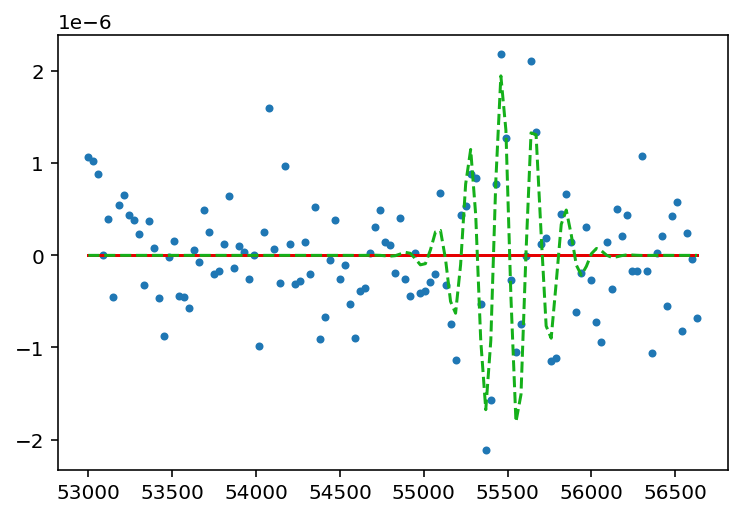

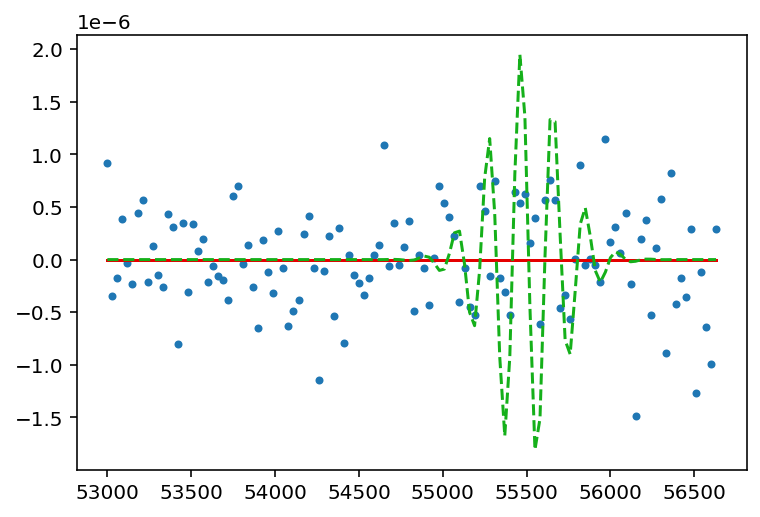

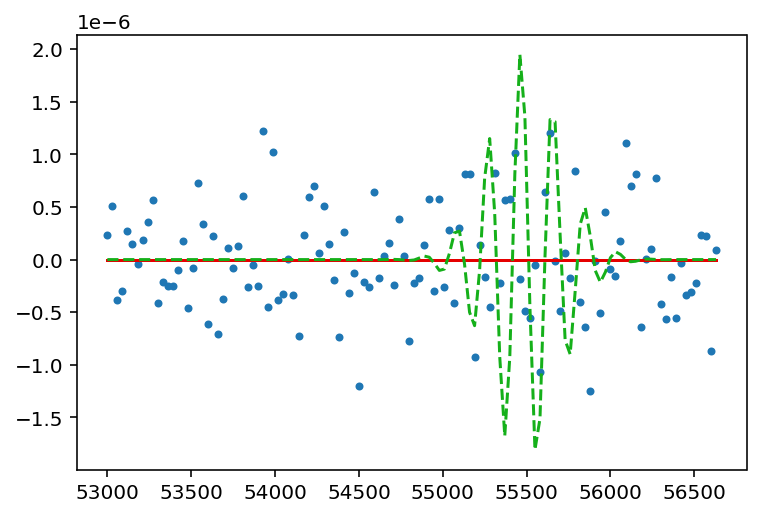

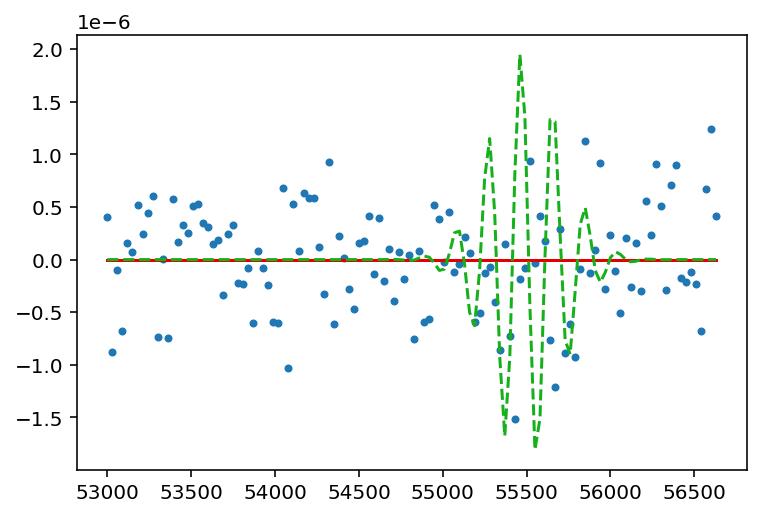

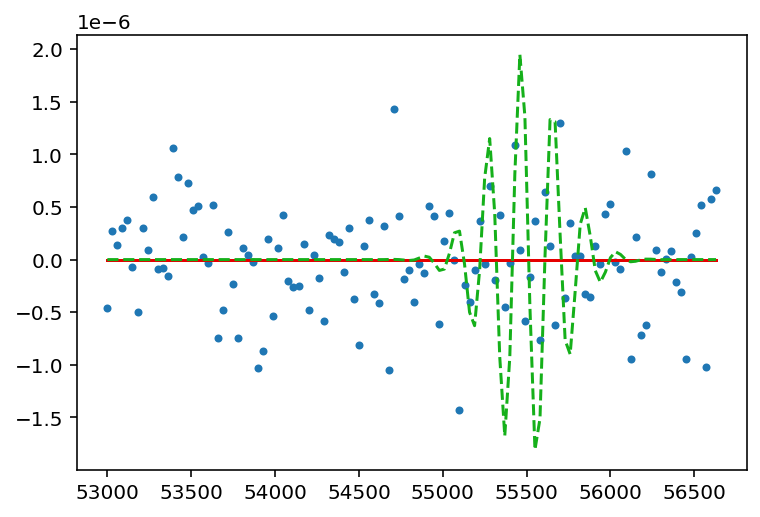

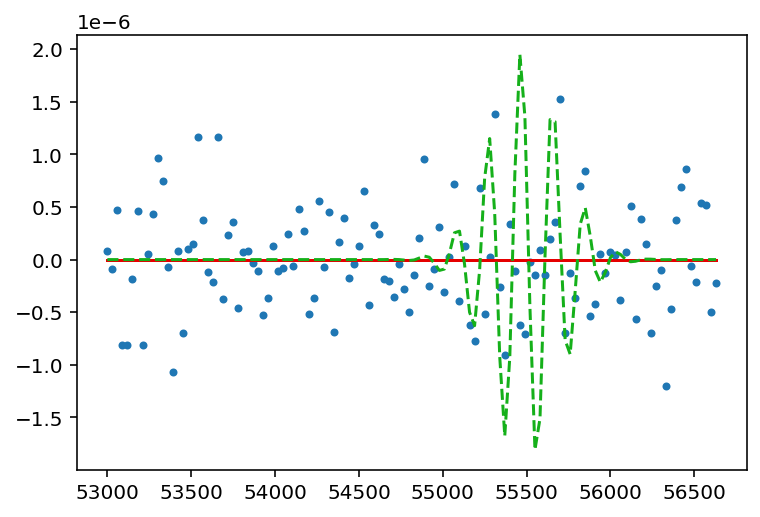

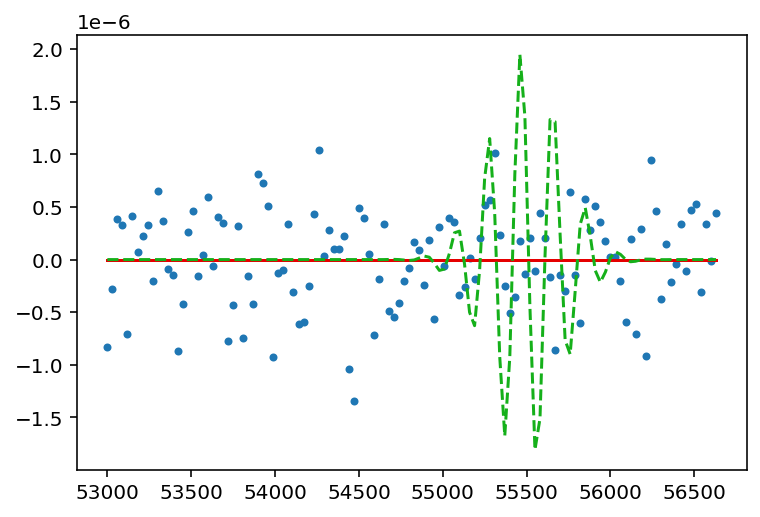

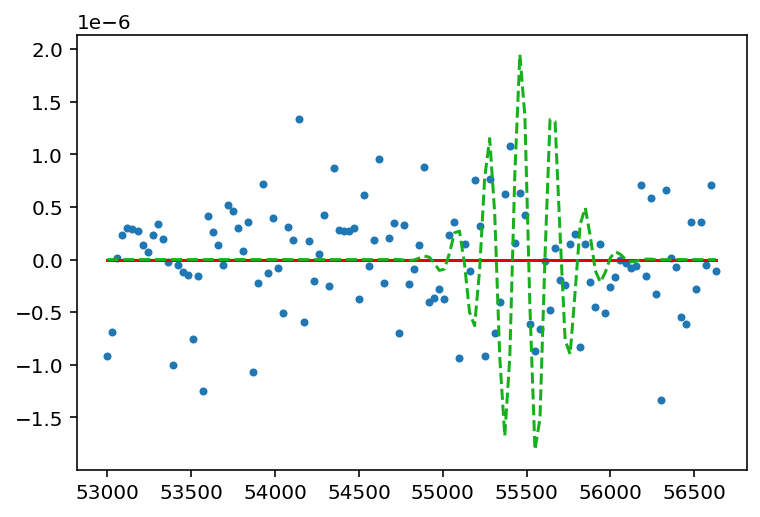

In [39]:
for i, psr in enumerate(psrs_sim):
    plt.figure(i)
    plt.plot(psr.toas/86400, psr.residuals, ls='', marker='.')
    plt.plot(psr.toas/86400, pta_sim.get_delay(d0)[i],color='xkcd:red')
    
    f0 = 10**(x0[0])
    tau = (3.15*10**7)*x0[5]
    t0 = (3.15*10**7)*x0[4]
    
    Cosine = np.exp(-1*((FB1.toas[i] - t0)/tau)**2)*np.cos(2*np.pi*f0*(FB1.toas[i] - t0))
    Sine = np.exp(-1*((FB1.toas[i] - t0)/tau)**2)*np.sin(2*np.pi*f0*(FB1.toas[i] - t0))
    print(FB1.sigma)
    fast_delay = FB1.sigma[0]*Cosine + FB1.sigma[1]*Sine
    plt.plot(psr.toas/86400, fast_delay, ls='--',color='xkcd:green')